Processing Data

In [104]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt

# Load portion of the TF cat_vs_dogs dataset
# tfds.disable_progress_bar()
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


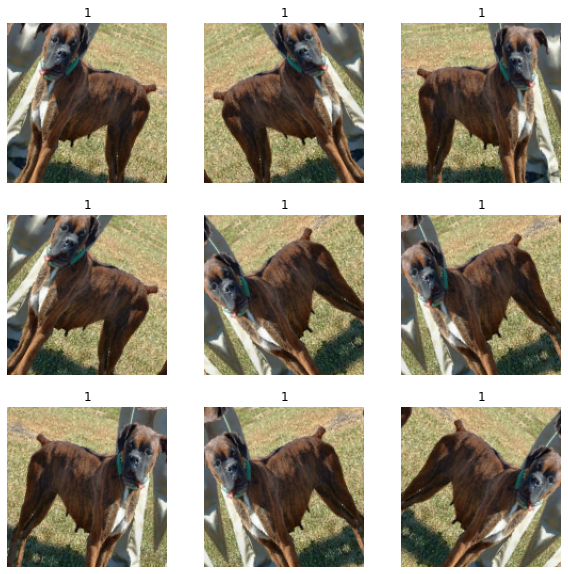

In [106]:
# Reshape into a good one 
size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)


data_augmentation = keras.Sequential(
    [preprocessing.RandomFlip("horizontal"), preprocessing.RandomRotation(0.1),]
)


Plotting

In [ ]:

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

Model Building

In [107]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = preprocessing.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [108]:
## Training top layer ()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 50s 142ms/step - loss: 0.1692 - binary_accuracy: 0.9264 - val_loss: 0.0814 - val_binary_accuracy: 0.9708
Epoch 2/20
291/291 [==============================] - 37s 128ms/step - loss: 0.1184 - binary_accuracy: 0.9484 - val_loss: 0.0742 - val_binary_accuracy: 0.9729
Epoch 3/20
291/291 [==============================] - 37s 129ms/step - loss: 0.1108 - binary_accuracy: 0.9558 - val_loss: 0.0757 - val_binary_accuracy: 0.9716
Epoch 4/20
291/291 [==============================] - 37s 128ms/step - loss: 0.1093 - binary_accuracy: 0.9556 - val_loss: 0.0717 - val_binary_accuracy: 0.9733
Epoch 5/20
291/291 [==============================] - 37s 129ms/step - loss: 0.1056 - binary_accuracy: 0.9593 - val_loss: 0.0719 - val_binary_accuracy: 0.9725
Epoch 6/20
291/291 [==============================] - 38s 129ms/step - loss: 0.1023 - binary_accuracy: 0.9594 - val_loss: 0.0693 - val_binary_accuracy: 0.9738
Epoch 7/20
291/291 [==========================

In [111]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds, batch_size=8)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

ResourceExhaustedError:  OOM when allocating tensor with shape[2048,1536,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/xception/block14_sepconv2/separable_conv2d (defined at Users\User\AppData\Local\Temp\ipykernel_24136\1271072309.py:16) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_137332]

Function call stack:
train_function
